In [1]:
import torch
import yaml
import gc
import warnings
import random
from utils import *
from tqdm import tqdm
import wandb
from datetime import datetime
import argparse
from torch.utils.data import DataLoader, random_split
import torch.optim.lr_scheduler as lr_scheduler

from trainer import Trainer 
# from MelGAN import Discriminator_MelGAN
# from MBSTFTD import MultiBandSTFTDiscriminator

## models
from models.model import MBSEANet
from models.model_tfilm import MBSEANet_film
from models.model_tfilm_sbr import MBSEANet_film_sbr
from models.prepare_models import prepare_generator, prepare_discriminator
## dataset
from dataset import CustomDataset
# from trainer import Trainer
from main import load_config, prepare_dataloader

config = load_config("configs/exp2.yaml")
# Prepare dataloaders
train_loader, val_loader = prepare_dataloader("configs/exp2.yaml")

DEVICE: cuda:0
Index:0 with 209759 samples
Index:1 with 131291 samples
Index:2 with 68249 samples
LR 409299 and HR 409299 file numbers loaded!
Index:0 with 43 samples
LR 43 and HR 43 file numbers loaded!


In [26]:
from pqmf import PQMF
from models.model_tfilm_sbr import MBSEANet_film_sbr

pqmf_fb = PQMF(num_subbands=32, num_taps=489, cutoff_ratio=None)

for data in train_loader:
    hr, lr, cond, name, _ = data
    break

model = MBSEANet_film_sbr(c_in=6, c_out=26, subband_num=26, min_dim=32, out_bias=False)
# model = MBSEANet_film(c_in=6, c_out=26, subband_num=26, min_dim=32, out_bias=False)

nb = pqmf_fb.analysis(lr)[:, :config['dataset']['start_index'], :]
hf_estimate, commitment_loss, codebook_loss = model(nb, cond)
target_subbands = pqmf_fb.analysis(hr)[:, config['dataset']['start_index']:, :] # target subbands [B,27,T]

Find an optimizal cutoff ratio for the PQMF...
Optimal cutoff ratio: 0.01778415
torch.Size([16, 6, 1360])
torch.Size([16, 32, 1360])


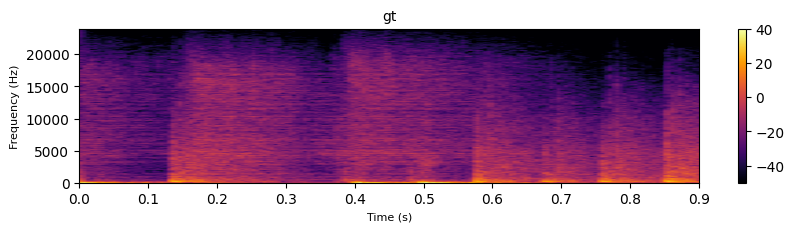

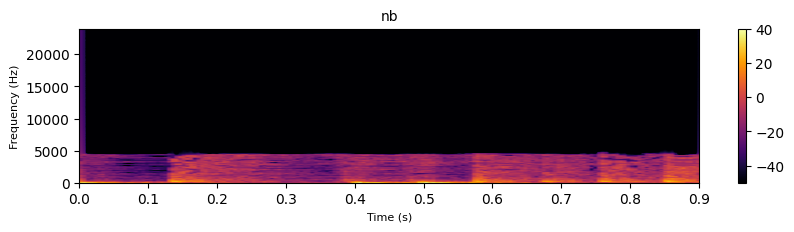

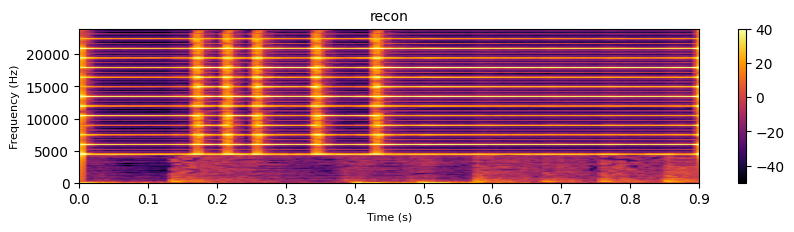

In [27]:
sr = 48000
FIGSIZE = (10,2)

from IPython.display import Audio, display

yhat = torch.cat([nb, hf_estimate], dim=1)
y_synthesis = pqmf_fb.synthesis(yhat, length=hr.shape[-1])

display(Audio(hr[0].squeeze().numpy(), rate=sr))
display(Audio(lr[0].detach().squeeze().numpy(), rate=sr))
display(Audio(y_synthesis[0].detach().squeeze().numpy(), rate=sr))
_=draw_spec(hr[0].squeeze().numpy(), sr=sr, figsize=FIGSIZE, title='gt')
_=draw_spec(lr[0].detach().squeeze().numpy(), sr=sr, figsize=FIGSIZE, title='nb')
_=draw_spec(y_synthesis[0].detach().squeeze().numpy(), sr=sr, figsize=FIGSIZE, title='recon')
